In [52]:
#!/usr/bin/env python
import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

__author__ = "Luksa Koch Vindbjerg"
__email__ = "201906015@post.au.dk"

is_done = False

def resetEnv(env):
    global is_done

    is_done = False
    env.reset()


# Load the gym environment
env8 = gym.make('Snake-8x8-v0')
env16 = gym.make('Snake-16x16-v0')

resetEnv(env8)
resetEnv(env16)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\lvind\.conda\envs\project_env\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\lvind\.conda\envs\project_env\lib\site-packages\gym\utils\passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
c:\Users\lvind\.conda\envs\project_env\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


Displaying the grid

c:\Users\lvind\.conda\envs\project_env\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
c:\Users\lvind\.conda\envs\project_env\lib\site-packages\gym\utils\passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
c:\Users\lvind\.conda\envs\project_env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


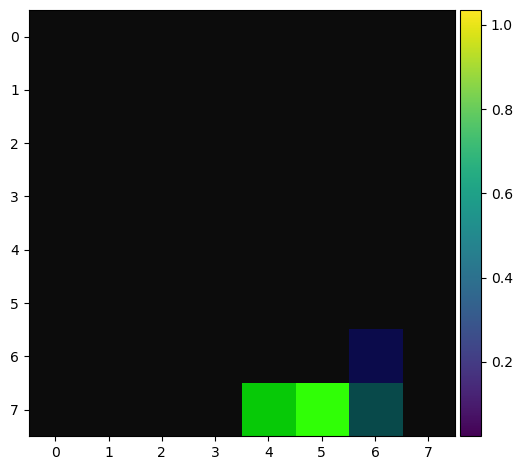

In [53]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(8, interpolation=Image.BOX),
                    T.ToTensor()])

def get_screen(fromEnv):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = fromEnv.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)
    # return screen.unsqueeze(0)


from skimage import io

last_screen = get_screen(env16)
env16.step(1)
current_screen = get_screen(env16)
img = current_screen + last_screen
# print(np.round(img))
io.imshow(img.squeeze(0).numpy().transpose(2, 1, 0))

    
                   

Loading CNN model

In [54]:
class old_model_architecture(nn.Module):
        def __init__(self, outputs):
            super(old_model_architecture, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
            self.maxpool1 = nn.MaxPool2d(kernel_size=2)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding='same')
            self.maxpool2 = nn.MaxPool2d(kernel_size=2)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding='same')
            self.bn1 = nn.BatchNorm2d(64)
            self.fc1 = nn.Linear(256, outputs)

        def forward(self, x):
            x = x.to(device)
            x = F.relu(self.conv1(x))
            x = self.maxpool1(x)
            x = F.relu(self.conv2(x))
            x = self.maxpool2(x)
            x = F.relu(self.conv3(x))
            x = self.bn1(x)
            x = self.fc1(x.view(x.size(0), -1))
            return x

In [55]:
"""initialize the model"""
path_cnn = 'models/snakeaiCNN1.pkl'
# \dl-project-grp21\src\models\snakeaiCNN1.pkl

test_model = old_model_architecture(env8.action_space.n).to(device)
test_model.load_state_dict(torch.load(path_cnn))
test_model.eval()


old_model_architecture(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
)

Testing the loaded model

In [56]:
""" Record 10 videos """

training = False

if(not training):

    num_episodes = 10

    env8 = gym.wrappers.RecordVideo(env8, 'video/transfer', episode_trigger = lambda x: x % 1 == 0)

    episode_reward = 0
    rewards = []

    for i_episode in range(num_episodes):

        # Initialize the environment and state
        env8.reset()
        last_screen = get_screen(env8)
        current_screen = get_screen(env8)
        state = current_screen + last_screen

        for t in count():
            # Select and perform an action
            action = test_model(state).max(1)[1].view(1, 1)
            _, reward, done, _ = env8.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(env8)
            if not done:
                next_state = current_screen + last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                rewards.append(episode_reward.item())
                break

c:\Users\lvind\.conda\envs\project_env\lib\site-packages\gym\wrappers\record_video.py:78: UserWarning: WARN: Overwriting existing videos at c:\Users\lvind\OneDrive\AU\7_semester\Deep Learning\dl_assignments\dl-project-grp21\src\video\transfer folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [57]:
tf_model_16 = old_model_architecture(env16.action_space.n).to(device)
tf_model_16.load_state_dict(torch.load(path_cnn))
tf_model_16.eval()


tf_model_16.fc1 = nn.Linear(256, env16.action_space.n)



In [ ]:
training = False

if(not training):

    num_episodes = 10

    env16 = gym.wrappers.RecordVideo(env8, 'video/transfer', episode_trigger = lambda x: x % 1 == 0)

    episode_reward = 0
    rewards = []

    for i_episode in range(num_episodes):

        # Initialize the environment and state
        env16.reset()
        last_screen = get_screen(env16)
        current_screen = get_screen(env16)
        state = current_screen + last_screen

        for t in count():
            # Select and perform an action
            action = tf_model_16(state).max(1)[1].view(1, 1)
            _, reward, done, _ = env16.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(env16)
            if not done:
                next_state = current_screen + last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                rewards.append(episode_reward.item())
                break